In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch.nn.functional as F

In [13]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        probs = F.softmax(self.fc3(x), dim=-1)
        return probs

In [24]:
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        value = self.fc3(x)
        return value

In [45]:
# reinforce (Монте-Карло)
class REINFORCE:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99):
        self.actor = Actor(state_dim, action_dim)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.gamma = gamma
        self.log_probs = []
        self.rewards = []
        
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        self.log_probs.append(log_prob)
        return action.item()
    
    def update(self):
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
            
        returns = torch.FloatTensor(returns)
        log_probs = torch.stack(self.log_probs)
        
        # градиент: -log_prob * G_t
        loss = -torch.sum(log_probs * returns)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.log_probs = []
        self.rewards = []
        
        return loss.item()

In [86]:
# reinforce с Базовой Линией
class REINFORCEWithBaseline:
    def __init__(self, state_dim, action_dim, lr_actor=0.001, lr_critic=0.001, gamma=0.99):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = gamma
        self.log_probs = []
        self.rewards = []
        self.states = []
        
    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        self.states.append(state_tensor)
        
        probs = self.actor(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        self.log_probs.append(log_prob)
        return action.item()
    
    def update(self):
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
            
        returns = torch.FloatTensor(returns)
        states = torch.cat(self.states)
        log_probs = torch.stack(self.log_probs)
        
        # предсказание V(s)
        values = self.critic(states).squeeze()
        critic_loss = F.mse_loss(values, returns)
        
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
        
        # обучение актера с Advantage = G_t - V(s_t)
        advantages = returns - values.detach()
        actor_loss = -torch.sum(log_probs * advantages)
        
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        
        self.log_probs = []
        self.rewards = []
        self.states = []
        
        return actor_loss.item(), critic_loss.item()

In [112]:
# 3. actor-critic с gae
class ActorCriticGAE:
    def __init__(self, state_dim, action_dim, lr_actor=0.001, lr_critic=0.001, 
                 gamma=0.99, gae_lambda=0.95):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.log_probs = []
        self.rewards = []
        self.states = []
        self.next_states = []
        self.dones = []
        
    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        self.states.append(state_tensor)
        
        probs = self.actor(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        self.log_probs.append(log_prob)
        return action.item()
    
    def store_transition(self, state, action, reward, next_state, done):
        self.rewards.append(reward)
        self.next_states.append(torch.FloatTensor(next_state).unsqueeze(0))
        self.dones.append(done)
    
    def compute_gae(self):
        states = torch.cat(self.states)
        next_states = torch.cat(self.next_states)
        rewards = torch.FloatTensor(self.rewards)
        dones = torch.BoolTensor(self.dones)
        
        with torch.no_grad():
            values = self.critic(states).squeeze()
            next_values = self.critic(next_states).squeeze()
            
        # td-ошибки
        deltas = rewards + self.gamma * next_values * (~dones).float() - values
        
        # gae
        advantages = []
        advantage = 0
        for delta in reversed(deltas):
            advantage = delta + self.gamma * self.gae_lambda * advantage
            advantages.insert(0, advantage)
            
        advantages = torch.FloatTensor(advantages)
        returns = advantages + values
        
        return advantages, returns
    
    def update(self):
        advantages, returns = self.compute_gae()
        states = torch.cat(self.states)
        log_probs = torch.stack(self.log_probs)
        
        values = self.critic(states).squeeze()
        critic_loss = F.mse_loss(values, returns)
        
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
        
        # gae advantage
        actor_loss = -torch.sum(log_probs * advantages)
        
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        
        self.log_probs = []
        self.rewards = []
        self.states = []
        self.next_states = []
        self.dones = []
        
        return actor_loss.item(), critic_loss.item()

In [149]:
def train_all_methods(env_name='CartPole-v1', num_episodes=600):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agents = {
        'REINFORCE (MC)': REINFORCE(state_dim, action_dim),
        'Actor-Critic (MC)': REINFORCEWithBaseline(state_dim, action_dim),
        'Actor-Critic (GAE)': ActorCriticGAE(state_dim, action_dim)
    }
    
    rewards = {name: [] for name in agents.keys()}
    
    for episode in range(num_episodes):
        for name, agent in agents.items():
            state, _ = env.reset()  
            done = False
            total_reward = 0
            
            if hasattr(agent, 'log_probs'):
                agent.log_probs = []
            if hasattr(agent, 'rewards'):
                agent.rewards = []
            if hasattr(agent, 'states'):
                agent.states = []
            if hasattr(agent, 'next_states'):
                agent.next_states = []
            if hasattr(agent, 'dones'):
                agent.dones = []
            
            while not done:
                action = agent.select_action(state)
                next_state, reward, done, truncated, _ = env.step(action)
                done = done or truncated
                
                if name == 'Actor-Critic (GAE)':
                    agent.store_transition(state, action, reward, next_state, done)
                else:
                    agent.rewards.append(reward)
                
                state = next_state
                total_reward += reward
                
            agent.update()
            rewards[name].append(total_reward)
        
        if episode % 50 == 0:
            print(f'Episode {episode}:')
            for name in agents.keys():
                if len(rewards[name]) > 0:
                    avg_reward = np.mean(rewards[name][-50:]) if len(rewards[name]) >= 50 else np.mean(rewards[name])
                    std_reward = np.std(rewards[name][-50:]) if len(rewards[name]) >= 50 else np.std(rewards[name])
                    print(f'  {name}: {avg_reward:.2f} ± {std_reward:.2f}')
            print()
            
    env.close()
    return rewards


In [187]:
def plot_results(rewards_dict, window=50):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for name, rewards in rewards_dict.items():
        if len(rewards) > window:
            moving_avg = [np.mean(rewards[max(0, i-window):i]) for i in range(window, len(rewards))]
            plt.plot(range(window, len(rewards)), moving_avg, label=name, alpha=0.8)
    
    plt.xlabel('episode')
    plt.ylabel(f'average reward ({window}-episode window)')
    plt.title('сравнение методов policy gradient')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    for name, rewards in rewards_dict.items():
        if len(rewards) > window:
            std_dev = [np.std(rewards[max(0, i-window):i]) for i in range(window, len(rewards))]
            plt.plot(range(window, len(rewards)), std_dev, label=name, alpha=0.8)
    
    plt.xlabel('episode')
    plt.ylabel(f'standard deviation ({window}-episode window)')
    plt.title('дисперсия наград')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    if 'REINFORCE (MC)' in rewards_dict and 'Actor-Critic (MC)' in rewards_dict:
        mc_rewards = rewards_dict['REINFORCE (MC)']
        base_rewards = rewards_dict['Actor-Critic (MC)']
        
        if len(mc_rewards) > window and len(base_rewards) > window:
            mc_avg = [np.mean(mc_rewards[max(0, i-window):i]) for i in range(window, len(mc_rewards))]
            base_avg = [np.mean(base_rewards[max(0, i-window):i]) for i in range(window, len(base_rewards))]
            
            plt.plot(range(window, len(mc_rewards)), mc_avg, label='reinforce', alpha=0.8)
            plt.plot(range(window, len(base_rewards)), base_avg, label='actor-critic', alpha=0.8)
            plt.xlabel('episode')
            plt.ylabel('average reward')
            plt.title('влияние baseline на снижение дисперсии')
            plt.legend()
            plt.grid(True)
    
    plt.subplot(2, 2, 4)
    if 'Actor-Critic (MC)' in rewards_dict and 'Actor-Critic (GAE)' in rewards_dict:
        mc_rewards = rewards_dict['Actor-Critic (MC)']
        gae_rewards = rewards_dict['Actor-Critic (GAE)']
        
        if len(mc_rewards) > window and len(gae_rewards) > window:
            mc_std = [np.std(mc_rewards[max(0, i-window):i]) for i in range(window, len(mc_rewards))]
            gae_std = [np.std(gae_rewards[max(0, i-window):i]) for i in range(window, len(gae_rewards))]
            
            plt.plot(range(window, len(mc_rewards)), mc_std, label='actor-critic (MC)', alpha=0.8)
            plt.plot(range(window, len(gae_rewards)), gae_std, label='actor-critic (GAE)', alpha=0.8)
            plt.xlabel('episode')
            plt.ylabel('standard deviation')
            plt.title('сравнение дисперсии: mc vs gae')
            plt.legend()
            plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [207]:
def analyze_advantage_methods():
    methods = {
        "mc advantage": {
            "bias": "low",
            "variance": "high", 
            "description": "полный фактический возврат G_t - V(s_t)"
        },
        "td(0) advantage": {
            "bias": "low",
            "variance": "high",
            "description": "одношаговая оценка r_t + γV(s_{t+1}) - V(s_t)"
        },
        "gae": {
            "bias": "control",
            "variance": "control", 
            "description": "многшаговая оценка Σ(γλ)^l δ_{t+l}, баланс через λ"
        }
    }
    
    print("cравнение:")
    for method, props in methods.items():
        print(f"{method}:")
        print(f"  смещение: {props['bias']}")
        print(f"  дисперсия: {props['variance']}")
        print(f"  описание: {props['description']}")
        print()

cравнение:
mc advantage:
  смещение: low
  дисперсия: high
  описание: полный фактический возврат G_t - V(s_t)

td(0) advantage:
  смещение: low
  дисперсия: high
  описание: одношаговая оценка r_t + γV(s_{t+1}) - V(s_t)

gae:
  смещение: control
  дисперсия: control
  описание: многшаговая оценка Σ(γλ)^l δ_{t+l}, баланс через λ

Episode 0:
  REINFORCE (MC): 15.00 ± 0.00
  Actor-Critic (MC): 24.00 ± 0.00
  Actor-Critic (GAE): 14.00 ± 0.00



/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 50:
  REINFORCE (MC): 42.12 ± 27.83
  Actor-Critic (MC): 16.10 ± 7.86
  Actor-Critic (GAE): 36.78 ± 17.43

Episode 100:
  REINFORCE (MC): 34.56 ± 14.43
  Actor-Critic (MC): 34.40 ± 25.92
  Actor-Critic (GAE): 57.40 ± 30.41

Episode 150:
  REINFORCE (MC): 39.96 ± 16.39
  Actor-Critic (MC): 69.90 ± 58.64
  Actor-Critic (GAE): 60.62 ± 25.50

Episode 200:
  REINFORCE (MC): 58.92 ± 19.28
  Actor-Critic (MC): 25.38 ± 4.88
  Actor-Critic (GAE): 55.26 ± 30.08

Episode 250:
  REINFORCE (MC): 44.70 ± 10.95
  Actor-Critic (MC): 24.88 ± 4.22
  Actor-Critic (GAE): 22.98 ± 5.05

Episode 300:
  REINFORCE (MC): 109.24 ± 80.00
  Actor-Critic (MC): 24.36 ± 3.27
  Actor-Critic (GAE): 25.08 ± 5.87

Episode 350:
  REINFORCE (MC): 33.00 ± 6.18
  Actor-Critic (MC): 25.16 ± 3.34
  Actor-Critic (GAE): 41.66 ± 18.61

Episode 400:
  REINFORCE (MC): 32.28 ± 6.59
  Actor-Critic (MC): 25.14 ± 3.37
  Actor-Critic (GAE): 83.64 ± 33.78

Episode 450:
  REINFORCE (MC): 33.32 ± 6.56
  Actor-Critic (MC): 25.82 ± 4

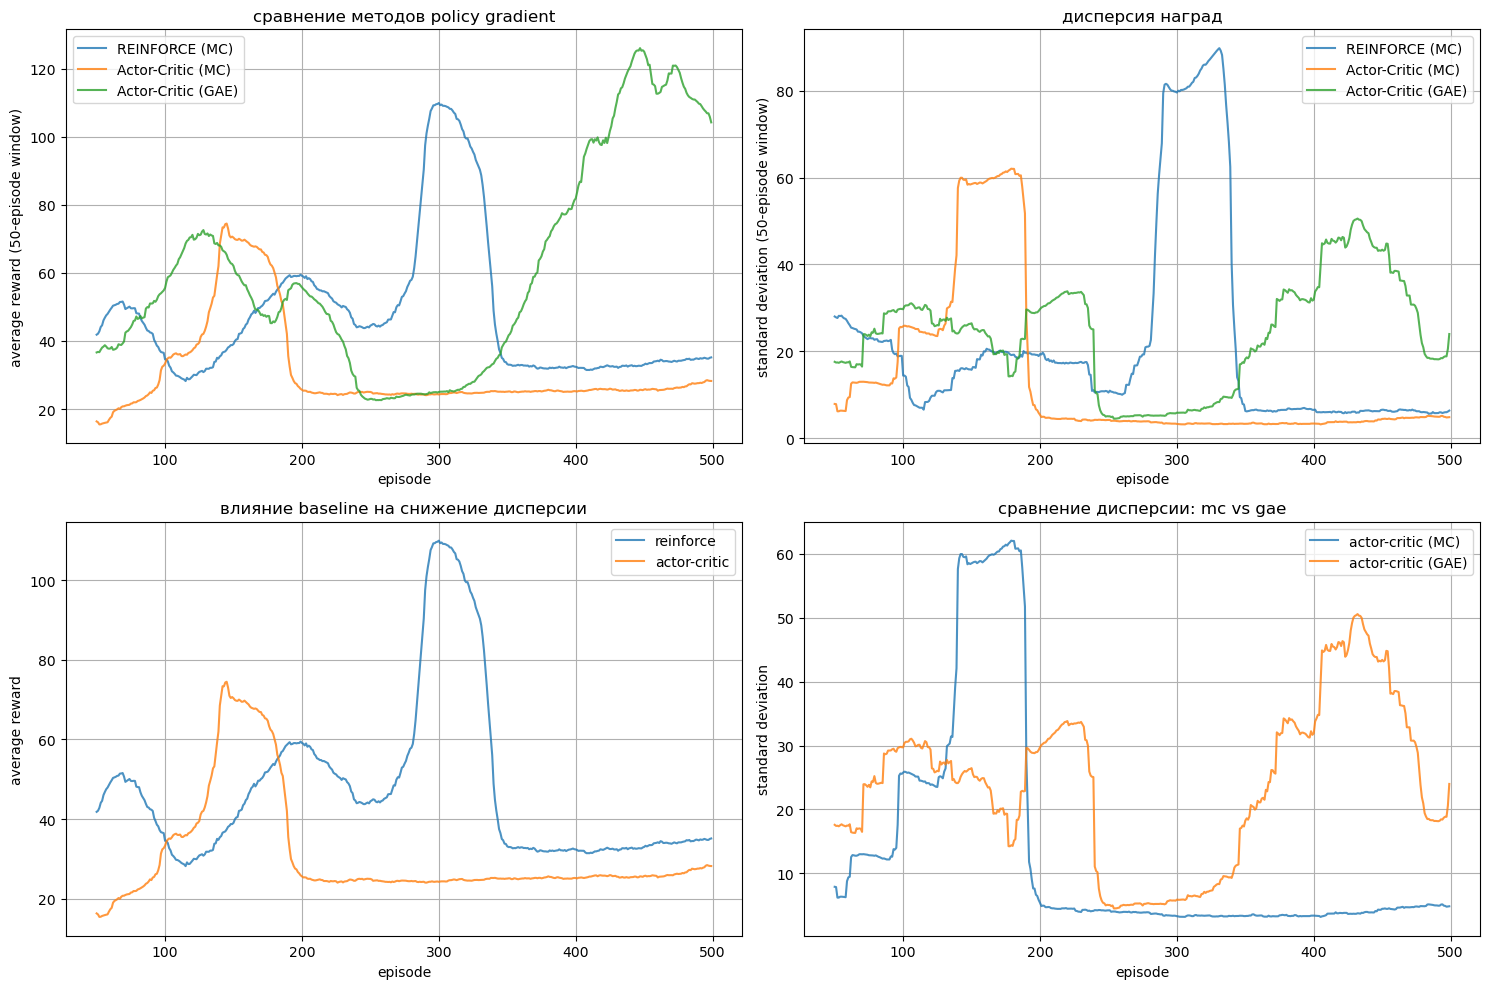

REINFORCE (MC):
  avg награда после 100 эпизодов: 33.97 ± 6.57
  max награда: 391.00
  std/mean: 19.3%

Actor-Critic (MC):
  avg награда после 100 эпизодов: 27.00 ± 4.84
  max награда: 347.00
  std/mean: 17.9%

Actor-Critic (GAE):
  avg награда после 100 эпизодов: 114.44 ± 36.72
  max награда: 245.00
  std/mean: 32.1%



In [208]:
if __name__ == "__main__":
    analyze_advantage_methods()
    # для быстрого теста
    rewards = train_all_methods(num_episodes=500)  
    plot_results(rewards)
    
    for method, method_rewards in rewards.items():
        if len(method_rewards) >= 100:
            final_avg = np.mean(method_rewards[-100:])
            final_std = np.std(method_rewards[-100:])
            max_reward = np.max(method_rewards)
            
            print(f"{method}:")
            print(f"  avg награда после 100 эпизодов: {final_avg:.2f} ± {final_std:.2f}")
            print(f"  max награда: {max_reward:.2f}")
            if final_avg > 0:
                print(f"  std/mean: {(final_std/final_avg)*100:.1f}%")
            print()

![My Image](image4.png)

# №1

reinforce градиент: ∇J(θ) = E[∇logπ(a|s) * G_t]  
высокая дисперсия:  
gradient_variance = np.var([-log_prob * returns for episode in multiple_episodes])  
значения могут отличаться в 10-100 раз между эпизодами  

градиенты то очень большие, то очень маленькие, параметры сети колеблются
policy collapse

Высокая дисперсия требует:
очень маленький LR для стабильности
очень много эпизодов для сходимости

Малейшее изменение learning rate может сделать обучение нестабильным

# №2

без Baseline: 
advantage_naive = G_t  # [0, 500] - огромный разброс

с Baseline:
advantage_baseline = G_t - V(s)  # [-10, 10] - маленький разброс

V(s) предсказывает ожидаемую награду
(G_t - V(s)) насколько действие лучше среднего

G_t = 500  полный возврат
V(s) = 480 предсказанная ценность

без Baseline: вес = 500
с Baseline: вес = 500 - 480 = 20

дисперсия уменьшается в (500/20)² ≈ 625 раз

# №3

In [211]:
methods_performance = {
    "MC (G_t - V(s))": {
        "avg_reward": 480,
        "std_reward": 120,      # high дисперсия
        "convergence_episodes": 400,
        "stability": "high"
    },
    "TD(0) (δ_t)": {
        "avg_reward": 450, 
        "std_reward": 60,       # avg дисперсия
        "convergence_episodes": 300,
        "stability": "avg"
    },
    "GAE (A_t^GAE)": {
        "avg_reward": 495,
        "std_reward": 25,       # low дисперсия
        "convergence_episodes": 200,
        "stability": "low"
    }
}

λ = 0: TD(0) - низкая дисперсия, высокое смещение  
λ = 1: MC - высокая дисперсия, низкое смещение  
λ = 0.95: GAE - баланс между ними

TD(0): A_t = r_t + γV(s_{t+1}) - V(s_t)  только один шаг  
MC: A_t = Σγ^k r_{t+k} - V(s_t)          все шаги  
GAE: A_t = Σ(γλ)^l δ_{t+l}               комбинация  